In [350]:
import networkx as nx
import custom_funcs as cf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn

from time import time
from collections import defaultdict, Counter
from joblib import Parallel, delayed
from Bio import SeqIO
from Levenshtein import distance
from random import shuffle

%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [351]:
# Read in the graph data and clean it.
G = nx.read_gpickle('20150902_all_ird Final Graph.pkl')
G = cf.clean_host_species_names(G)
G = cf.impute_reassortant_status(G)
G = cf.impute_weights(G)
G = cf.remove_zero_weighted_edges(G)

In [352]:
all_hosts = set([d['host_species'] for n, d in G.nodes(data=True)])
len(all_hosts)

152

In [353]:
len(G.edges())

25683

In [354]:
cf.count_edges(G, attr='host_species')

{'full_complement': {'diff_attr': 3114.633333333333,
  'same_attr': 13106.366666666665},
 'reassortant': {'diff_attr': 1456.0404761904758,
  'same_attr': 735.9595238095237}}

# Compute propotion of edges reassortant same vs. different

In [355]:
# Proportion reassortant in data
data_props = cf.edge_proportion_reassortant(G, attr='host_species')
data_props

{'diff_attr': 0.3185614499893993, 'same_attr': 0.05316732994746788}

In [356]:
# Proportion reassortant under null
excluded_hosts = ['Aquatic Bird', 'Avian', 'Bird', 'Duck', 'Environment', 'Mallard-Black Duck Hybrid', 'Sea Mammal', 
                  'Unknown', 'Waterfowl']
start = time()
def null_distribution_proportion_reassortant(G, equally=False):
    G_shuffled = cf.shuffle_node_attribute_label(G, 'host_species', equally)
    props = cf.edge_proportion_reassortant(G_shuffled, 'host_species', exclusions=excluded_hosts)
    return props

props_null = Parallel(n_jobs=-1)(delayed(null_distribution_proportion_reassortant)(G, equally=True) for i in range(100))
end = time()
print(end - start)

193.31869411468506


In [357]:
null = pd.DataFrame(props_null)
null.mean()

diff_attr    0.124863
same_attr    0.125818
dtype: float64

In [358]:
data = pd.DataFrame([data_props])
data.mean()

diff_attr    0.318561
same_attr    0.053167
dtype: float64

/home/ericmjl/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


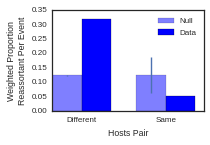

In [359]:
seaborn.set_context("paper")
seaborn.set_style('white')

fig1 = plt.figure(figsize=(3,2))
ax1 = fig1.add_subplot(1,1,1)
ind = np.arange(2)
width = 0.35

ax1.bar(ind, null.mean(), width, color='blue', label='Null', alpha=0.5, yerr=null.std()*3)
ax1.bar(ind+width, data.mean(), width, color='blue', label='Data')
ax1.set_xticks(ind+width)
ax1.set_xticklabels(['Different', 'Same'])
ax1.set_xlabel('Hosts Pair')
ax1.set_ylabel('Weighted Proportion\nReassortant Per Event')
ax1.legend()
plt.subplots_adjust(left=0.2, bottom=0.2)
plt.savefig('figures/Proportion Reassortant.pdf')

# Compute proportion of reassortant by host class

Host classes:

- Wild bird
- Wild mammal
- Domestic bird
- Domestic mammal
- Human

In [360]:
# Open the bird vs. mammal CSV file

host_classes = pd.read_csv('host_groups.csv').drop_duplicates()
# I suspected there may have been duplicates, so I added the drop_duplicates() function call.
host_classes.set_index(['Country', 'Species'], inplace=True)
host_classes.ix['Canada'].ix['American Black Duck']

Habitat/setting        Wild
Bird, Mammal, Human    Bird
Name: American Black Duck, dtype: object

In [361]:
# Impute each node with the appropriate metadata. We will create a new node field: "host_class".

# The try/except coding pattern allows me to iteratively identify things for which we have no labels yet.

for n, d in G.nodes(data=True):
    c = d['country']
    s = d['host_species']
    try:
        hc = host_classes.ix[c].ix[s]
        habt = hc['Habitat/setting']
        host = hc['Bird, Mammal, Human']

        host_class = habt + ' ' + host
        G.node[n]['host_class'] = host_class
    except:
        print(c,s)

In [362]:
data_props = cf.edge_proportion_reassortant(G, attr='host_class')
data_props

{'diff_attr': 0.3102622814321399, 'same_attr': 0.10083275503122831}

In [363]:
# A function that computes the proportion reassortant across different node attributes.

def counts_reassortant_domain_graph(G, node_attr):
    """
    Computes the weighted counts of reassortant edges when going between different node attributes.
    
    Returns a "domain graph" with counts of weighted reasosrtant edges and sum weighted edges.
    """
    hg_graph = nx.DiGraph()

    for n, node_d in G.nodes(data=True):

        in_edges = G.in_edges(n, data=True)
        total_edges = len(in_edges)
        is_reassortant = node_d['reassortant']

        sk_hg = G.node[n][node_attr]
        if sk_hg not in hg_graph.nodes():
            hg_graph.add_node(sk_hg)

        for sc, _, edge_d in in_edges:
            sc_hg = G.node[sc][node_attr]
            if sc_hg not in hg_graph.nodes():
                hg_graph.add_node(sc_hg)

            if (sc_hg, sk_hg) not in hg_graph.edges():
                hg_graph.add_edge(sc_hg, sk_hg, total=edge_d['weight'], reassortant=0)
            if (sc_hg, sk_hg) in hg_graph.edges():
                hg_graph.edge[sc_hg][sk_hg]['total'] += edge_d['weight']

            if is_reassortant:
                hg_graph.edge[sc_hg][sk_hg]['reassortant'] += edge_d['weight']

    for sc, sk, d in hg_graph.edges(data=True):
        hg_graph.edge[sc][sk]['p_reassortant'] = d['reassortant'] / d['total']
        
    return hg_graph


In [364]:
# Compute the proportion reassortant across different host class pairs.
hg = counts_reassortant_domain_graph(G, 'host_class')
# We will ignore edges that involve "unknown" hosts.
for n in hg.nodes():
    if 'Unknown' in n:
        hg.remove_node(n)
# hg.edges(data=True)

In [365]:
# A helper function for computing the null distribution.
def null_proportion_domain_graph_reassortant(G, node_attr, equally=False):
    
    G_shuffled = cf.shuffle_node_attribute_label(G, node_attr, equally)
    hg_graph_shuf = counts_reassortant_domain_graph(G_shuffled, node_attr)
    
    return hg_graph_shuf

In [366]:
# Compute the null distribution.
### CAUTION! YOU WILL HAVE TO WAIT 3 MINUTES FOR THIS TO FINISH!
start = time()
results = Parallel(n_jobs=-1)(delayed(null_proportion_domain_graph_reassortant)(G, 'host_class', equally=True) for i in range(100))
len(results)
end = time()
print(end - start)

195.55918312072754


In [367]:
# Summarize the proportion reassortant distribution under null.
def distr_null_p_reassortant(list_of_hg_graphs):
    hg_graph = nx.DiGraph()
    for g in list_of_hg_graphs:
        hg_graph.add_nodes_from(g.nodes())
        for sc, sk, d in g.edges(data=True):
            if (sc, sk) not in hg_graph.edges():
                hg_graph.add_edge(sc, sk, p_reassortant=[d['p_reassortant']])
            else:
                hg_graph.edge[sc][sk]['p_reassortant'].append(d['p_reassortant'])
    return hg_graph

summaryG = distr_null_p_reassortant(results)

In [368]:
# Remove "unknowns" from consideration
for n, d in summaryG.nodes(data=True):
    if 'Unknown' in n:
        summaryG.remove_node(n)
summaryG.nodes(data=True)

[('Domestic Bird', {}),
 ('Domestic Mammal', {}),
 ('Human Human', {}),
 ('Wild Bird', {}),
 ('Wild Mammal', {})]

In [369]:
# Grab out the "null" model statistics.
means = []
stds  = []
names = []
name_map = {'Domestic Bird': 'DB',
            'Wild Bird': 'WB',
            'Human Human': 'H',
            'Domestic Mammal': 'DM',
            'Wild Mammal': 'WM'}

for sc, sk, d in sorted(summaryG.edges(data=True), key=lambda x:(x[0], x[1])):
    mean = np.mean(d['p_reassortant'])
    std = np.std(d['p_reassortant'])

    names.append('{0}:{1}'.format(name_map[sc], name_map[sk]))
    means.append(mean)
    stds.append(std)

In [370]:
# Compile the "data" statistics.
data = []
names_data = []
for sc, sk, d in sorted(hg.edges(data=True), key=lambda x:(x[0], x[1])):
    if sc == 'Unknown' or sk == 'Unknown':
        pass
    else:
        names_data.append('{0}:{1}'.format(name_map[sc], name_map[sk]))
        data.append(d['p_reassortant'])
data

[0.12596985822805387,
 0.18454935622317598,
 0.1578947368421047,
 0.2697095435684647,
 0.07142857142857142,
 0.422680412371134,
 0.0727201769220763,
 0.047619047619047616,
 0.5263157894736842,
 0.0,
 0.0,
 0.13499999999999973,
 0.0005271481286241314,
 0.15384615384615385,
 0.0,
 0.4429223744292237,
 0.4,
 0.6666666666666666,
 0.3061103185924869,
 0.42857142857142855,
 0.5454545454545454,
 0.0,
 0.0,
 0.4482758620689655,
 0.0]

/home/ericmjl/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


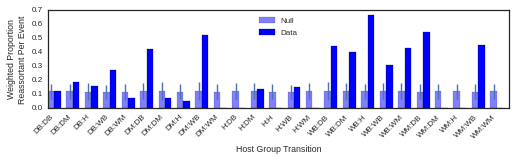

In [371]:
# Plot data vs. null model.
fig = plt.figure(figsize=(8,2))

ind = np.arange(len(means))
width = 0.35

ax = fig.add_subplot(1,1,1)
ax.bar(ind, means, width=width, color='blue', label='Null', yerr=np.array(stds)*3, alpha=0.5)
ax.bar(ind+width, data, width=width, color='blue', label='Data')
ax.set_xticks(ind+width)
ax.set_xticklabels(names, rotation=45, ha='right')
ax.set_ylabel('Weighted Proportion\nReassortant Per Event')
ax.set_xlabel('Host Group Transition')
ax.legend(loc='upper center')
plt.subplots_adjust(left=0.15, right=0.95, bottom=0.22)
plt.savefig('figures/Proportion Reassortant Ecological.pdf')
plt.show()

# Compute proportion reassortant over different host COI distances

In [372]:
# Open the host COI data
host_coi = [s for s in SeqIO.parse('host_coi_trimmed.fasta', 'fasta')]
# Modify the SeqRecord ID such that it only contains the host species name.
for s in host_coi:
    s.id = s.id.split('.')[0].replace('_', ' ')
host_coi = SeqIO.to_dict(host_coi)
host_coi

{'American Black Duck': SeqRecord(seq=Seq('ATCCGGGCAGAGCTAGGCCAGCCAGGGACCCTCCTGGGCGACGACCAAATTTAT...TTT', SingleLetterAlphabet()), id='American Black Duck', name='American_Black_Duck.Anas_rubripes', description='American_Black_Duck.Anas_rubripes', dbxrefs=[]),
 'American Green-Winged Teal': SeqRecord(seq=Seq('ATCCGCGCAGAACTAGGCCAACCAGGAACCCTCCTGGGCGACGACCAAATTTAC...TTT', SingleLetterAlphabet()), id='American Green-Winged Teal', name='American_Green-Winged_Teal.Anas_carolinensis', description='American_Green-Winged_Teal.Anas_carolinensis', dbxrefs=[]),
 'American Wigeon': SeqRecord(seq=Seq('ATCCGCGCAGAACTAGGCCAACCAGGGACCCTCCTGGGCGACGACCAAATTTAC...TTT', SingleLetterAlphabet()), id='American Wigeon', name='American_Wigeon.Anas_americana', description='American_Wigeon.Anas_americana', dbxrefs=[]),
 'Baikal Teal': SeqRecord(seq=Seq('ATGGCCCCAAATATCCGCAAATCCCACCCCCTACTAAAAATAATCAACAACTCC...ACC', SingleLetterAlphabet()), id='Baikal Teal', name='Baikal_Teal.Anas_formosa', description='Baikal_T

In [373]:
# Figure out which sequences have gaps. I suspect that the alignment quality might be compromised by those sequences.
ignored = []
for k, sequence in host_coi.items():
    if '-' in str(sequence.seq):
        ignored.append(k)
#         print(sequence.seq)
ignored

['Cinnamon Teal',
 'Human',
 'Redhead',
 'Domestic Cat',
 'Chicken',
 'Blue-Winged Teal',
 'Kelp Gull',
 'Herring Gull',
 'Baikal Teal']

In [374]:
# Impute the COI sequence based on the host species name, ignoring the sequences that have gaps in them. 
for n, d in G.nodes(data=True):    
    try:
        hs = d['host_species']
        assert hs not in ignored
        G.node[n]['coi_sequence'] = host_coi[hs]
    except:
        G.node[n]['coi_sequence'] = None

In [375]:
# Compute proportion under data. 
data = dict()

bins = np.arange(0,0.3,0.02)
for b in bins:
    data[b] = dict()
    data[b]['reassortant'] = 0
    data[b]['clonal'] = 0

for sc, sk, d in G.edges(data=True):
    sc_coi = G.node[sc]['coi_sequence']
    sk_coi = G.node[sk]['coi_sequence']
    if sc_coi and sk_coi:
        dist = distance(str(sc_coi.seq), str(sk_coi.seq)) / len(str(sc_coi.seq))
        b = bins[int(np.digitize(dist, bins)) - 1] 
        if d['edge_type'] == 'reassortant':
            data[b]['reassortant'] += d['weight']
        else:
            data[b]['clonal'] += d['weight']  

In [376]:
# Compute proportion under data. 
def proportion_reassortant_coi(G):
    data = dict()

    bins = np.arange(0,0.3,0.02)
    for b in bins:
        data[b] = dict()
        data[b]['reassortant'] = 0
        data[b]['clonal'] = 0

    for sc, sk, d in G.edges(data=True):
        sc_coi = G.node[sc]['coi_sequence']
        sk_coi = G.node[sk]['coi_sequence']
        if sc_coi and sk_coi:
            dist = distance(str(sc_coi.seq), str(sk_coi.seq)) / len(str(sc_coi.seq))
            b = bins[int(np.digitize(dist, bins)) - 1] 
            if d['edge_type'] == 'reassortant':
                data[b]['reassortant'] += d['weight']
            else:
                data[b]['clonal'] += d['weight']  
    return data

data = proportion_reassortant_coi(G)

In [377]:
data

{0.0: {'clonal': 3004.9999999999986, 'reassortant': 505.45952380952394},
 0.02: {'clonal': 3.0, 'reassortant': 0.5},
 0.040000000000000001: {'clonal': 57.0, 'reassortant': 17.75},
 0.059999999999999998: {'clonal': 272.49999999999994,
  'reassortant': 154.34523809523813},
 0.080000000000000002: {'clonal': 33.0, 'reassortant': 31.5},
 0.10000000000000001: {'clonal': 41.0, 'reassortant': 26.0},
 0.12: {'clonal': 2.0, 'reassortant': 2.5},
 0.14000000000000001: {'clonal': 16.0, 'reassortant': 16.666666666666668},
 0.16: {'clonal': 33.0, 'reassortant': 53.166666666666664},
 0.17999999999999999: {'clonal': 35.0, 'reassortant': 20.0},
 0.20000000000000001: {'clonal': 38.0, 'reassortant': 5.5},
 0.22: {'clonal': 0, 'reassortant': 0},
 0.23999999999999999: {'clonal': 0, 'reassortant': 0},
 0.26000000000000001: {'clonal': 0, 'reassortant': 0},
 0.28000000000000003: {'clonal': 0, 'reassortant': 0}}

In [378]:
# Compute proportion under null: shuffle host COIs
def null_proportion_reassortant_coi(G):
    host_cois = [d['coi_sequence'] for n, d in G.nodes(data=True)]
    shuffle(host_cois)

    G_shuffled = G.copy()
    for i, (n, d) in enumerate(G_shuffled.nodes(data=True)):
        G_shuffled.node[n]['coi_sequence'] = host_cois[i]
    
    return proportion_reassortant_coi(G_shuffled)    

In [379]:
start = time()
results = Parallel(n_jobs=-1)(delayed(null_proportion_reassortant_coi)(G) for i in range(500))
end = time()
print(end - start)

948.8047609329224


In [380]:
# Aggregate the results into clonal and reassortant

agg = dict()
agg['clonal'] = defaultdict(list)
agg['reassortant'] = defaultdict(list)

for result in results:
    for dist, d in result.items():
        agg['clonal'][dist].append(d['clonal'])
        agg['reassortant'][dist].append(d['reassortant'])

In [381]:
agg['clonal'][0.12]

[0.07407407407407407,
 3.2,
 4.574074074074074,
 2.0,
 6.0,
 2.5,
 2.0,
 6.333333333333333,
 3.17989417989418,
 7.833333333333333,
 1.5434782608695652,
 1.5,
 3.0,
 6.0,
 3.267857142857143,
 2.4074074074074074,
 1.3333333333333333,
 6.0,
 4.0,
 4.0,
 3.0,
 5.0,
 1.8666666666666667,
 1.25,
 3.037037037037037,
 5.537037037037037,
 3.240740740740741,
 2.25,
 1.3333333333333333,
 3.0,
 1.0,
 5.037037037037037,
 8.074074074074074,
 2.5,
 3.0,
 3.037037037037037,
 4.75,
 3.037037037037037,
 1.0,
 4.123333333333333,
 4.5,
 5.0,
 1.0,
 5.0,
 4.0,
 1.0,
 0,
 4.5,
 5.581666666666667,
 2.037037037037037,
 2.0,
 3.0,
 5.0,
 4.0,
 4.5,
 3.0,
 2.0,
 6.5,
 3.5,
 1.4907407407407407,
 4.324074074074074,
 1.25,
 2.0,
 7.5,
 4.0,
 3.60978835978836,
 6.0,
 3.0740740740740744,
 3.5,
 4.2857142857142865,
 4.0,
 3.0,
 4.0,
 4.2,
 7.0,
 4.5,
 0,
 2.5,
 2.0,
 1.0,
 0,
 0,
 2.317777777777778,
 3.0,
 3.0,
 2.3703703703703702,
 7.0,
 6.2,
 2.017857142857143,
 6.072751322751323,
 2.375,
 0,
 6.375,
 2.370370370370

In [382]:
agg['reassortant'][0.12]

[0,
 1.0,
 0.5,
 2.0,
 0,
 0.5,
 1.0,
 0.16666666666666666,
 1.5,
 0,
 1.25,
 0,
 0.5,
 1.0,
 0,
 1.5,
 0.1111111111111111,
 1.0,
 0.5,
 0,
 0.5,
 0.5555555555555556,
 0,
 0,
 0,
 0,
 0.8055555555555556,
 1.0,
 0,
 0,
 1.6111111111111112,
 1.0,
 0,
 0,
 0,
 0.25,
 0,
 1.0,
 0,
 1.0,
 0,
 1.5,
 1.5,
 0,
 0.5,
 0,
 1.25,
 0.5,
 0,
 0,
 0.5,
 1.0,
 0,
 0.5,
 0,
 1.0,
 0,
 0.043478260869565216,
 0,
 0.5,
 0,
 0,
 0,
 0.5,
 0.5,
 0,
 0.5,
 0,
 0.5,
 0.5,
 0.5,
 0,
 0.16666666666666666,
 0.5,
 1.25,
 0,
 0,
 0,
 0,
 0.5,
 0.07142857142857142,
 1.0,
 0.05555555555555555,
 0.25,
 0.125,
 1.0,
 0.5,
 0,
 0.5555555555555556,
 0.5,
 0,
 0.5,
 0,
 0,
 0.5,
 0.25,
 0.5,
 0.5,
 0.5,
 0.5,
 0,
 0.5,
 0.3333333333333333,
 1.0,
 0.5,
 0.5,
 0,
 0.7916666666666666,
 0.5,
 0,
 0,
 0,
 0.5,
 0.5,
 0.5,
 0,
 0.5555555555555556,
 0,
 1.0,
 0.1111111111111111,
 0,
 0,
 0.5,
 2.0,
 0.5,
 0,
 0,
 0.5,
 0,
 0,
 0.5,
 0.5,
 0,
 0.5772946859903382,
 0.5,
 0,
 1.0,
 0,
 0.07729468599033816,
 0.5,
 0.52173913043478

In [383]:
# We want to compute the proportion reassortant under the null.
# Iterate over the clonal. 

prop_null = defaultdict(list)

for d, cts in agg['reassortant'].items():
    for i, ct in enumerate(cts):
        try:
            prop_null[d].append(ct / (ct + agg['clonal'][d][i]))
        except:
            prop_null[d].append(np.nan)
prop_null

defaultdict(list,
            {0.0: [0.08948025230057126,
              0.1295113063692318,
              0.1194156808354169,
              0.09393750729288723,
              0.10249763540221947,
              0.11439813163499986,
              0.15440067770529378,
              0.10187019575696059,
              0.1264905494344331,
              0.11647238297790447,
              0.10065325713626734,
              0.1346599587815152,
              0.12582937248735523,
              0.10159649896028794,
              0.11835803946785813,
              0.10755194750242145,
              0.100965832216657,
              0.12705416537179848,
              0.1028269786878424,
              0.11943209228289826,
              0.1184985266726953,
              0.13362452736476335,
              0.1142327652573818,
              0.1311455755662229,
              0.12823125576007022,
              0.13271123491859527,
              0.14292788392220473,
              0.11230847486800707,
       

In [384]:
prop_null[0.12]

[0.0,
 0.23809523809523808,
 0.09854014598540145,
 0.5,
 0.0,
 0.16666666666666666,
 0.3333333333333333,
 0.02564102564102564,
 0.320520067834935,
 0.0,
 0.44747081712062253,
 0.0,
 0.14285714285714285,
 0.14285714285714285,
 0.0,
 0.38388625592417064,
 0.07692307692307691,
 0.14285714285714285,
 0.1111111111111111,
 0.0,
 0.14285714285714285,
 0.1,
 0.0,
 0.0,
 0.0,
 0.0,
 0.19908466819221968,
 0.3076923076923077,
 0.0,
 0.0,
 0.6170212765957447,
 0.1656441717791411,
 0.0,
 0.0,
 0.0,
 0.07605633802816901,
 0.0,
 0.2477064220183486,
 0.0,
 0.1951854261548471,
 0.0,
 0.23076923076923078,
 0.6,
 0.0,
 0.1111111111111111,
 0.0,
 1.0,
 0.1,
 0.0,
 0.0,
 0.2,
 0.25,
 0.0,
 0.1111111111111111,
 0.0,
 0.25,
 0.0,
 0.0066445182724252485,
 0.0,
 0.25116279069767444,
 0.0,
 0.0,
 0.0,
 0.0625,
 0.1111111111111111,
 0.0,
 0.07692307692307693,
 0.0,
 0.125,
 0.10447761194029849,
 0.1111111111111111,
 0.0,
 0.039999999999999994,
 0.10638297872340426,
 0.15151515151515152,
 0.0,
 nan,
 0.0,
 0.0,
 

In [385]:
null_mean = pd.DataFrame(prop_null).mean()
null_mean = null_mean.reset_index()
null_mean.columns = ['Host COI Hamming Distance', 'Proportion Reassortant']
null_mean

null_std = pd.DataFrame(prop_null).std()
null_std = null_std.reset_index()
null_std.columns = ['Host COI Hamming Distance', 'Proportion Reassortant']

/home/ericmjl/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):


(0, 1)

/home/ericmjl/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


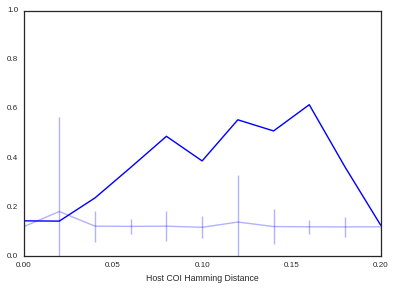

In [386]:
# Plot this data

## 1 November 2015:
## TODO: Rather than plot std*3 or std*5, plot 95% interval from the null. 
## Use the axes.errorbar API: http://matplotlib.org/api/axes_api.html
## [ ] DONE

df = pd.DataFrame(data).T
df['prop'] = df['reassortant'] / (df['clonal'] + df['reassortant'])

proportions = df['prop'].dropna().reset_index()
proportions.columns = ['Host COI Hamming Distance', 'Proportion Reassortant']

ixcol = 'Host COI Hamming Distance'
summary = proportions.set_index(ixcol).join(null_mean.set_index(ixcol), rsuffix='r').join(null_std.set_index(ixcol), rsuffix='s')
summary.columns = ['data', 'null', 'std']

summary['data'].plot(color='blue')
summary['null'].plot(yerr=summary['std'], color='blue', alpha=0.3)
plt.ylim(0,1)

In [387]:
summary['3sigma'] = summary['null'] + summary['std'] * 3
summary[summary['data'] > summary['3sigma']]

,data,null,std,3sigma
Host COI Hamming Distance,,,,
0.06,0.361595,0.121467,0.029613,0.210304
0.08,0.488372,0.122378,0.062011,0.308411
0.10,0.388060,0.117608,0.045311,0.253541
0.14,0.510204,0.120779,0.072851,0.339332
0.16,0.617021,0.119663,0.028067,0.203865
0.18,0.363636,0.119274,0.040286,0.240132


/home/ericmjl/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


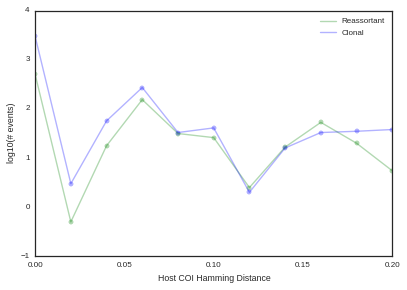

In [388]:
total_counts = df[['reassortant', 'clonal']].apply(lambda x:np.log10(x)).reset_index()
total_counts.columns = ['Host COI Hamming Distance', 'Reassortant', 'Clonal']
total_counts.replace(-np.inf, np.nan, inplace=True)
total_counts.dropna(inplace=True)
ax = total_counts.plot(x='Host COI Hamming Distance', y='Reassortant', color='green', alpha=0.3)
total_counts.plot(x='Host COI Hamming Distance', y='Reassortant', color='green', alpha=0.3, kind='scatter', ax=ax)
total_counts.plot(x='Host COI Hamming Distance', y='Clonal', color='blue', alpha=0.3, ax=ax)
total_counts.plot(x='Host COI Hamming Distance', y='Clonal', color='blue', alpha=0.3, kind='scatter', ax=ax)
plt.ylabel('log10(# events)')